# DenseNET on Rock_Paper_Scissors Dataset

In [ ]:
! pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Libraries

In [ ]:
import opendatasets as od
import PIL
import glob
import numpy as np
import sklearn
import tensorflow as tf
from tensorflow import keras
import os
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
import pandas as pd
from sklearn import model_selection
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, AveragePooling2D, GlobalAveragePooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import numpy as np
from tabulate import tabulate
import pandas as pd


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def mount_drive(fr = False):
    from google.colab import drive
    drive.mount("/content/drive/", force_remount = fr)

# Data Loading

In [ ]:
def fetch_rps(shuffle = False, train_test_split = True, random_state = 0, train_size = 0.8):

    mount_drive(False)
    
    rocklst, paperlst, scissorslst = glob.glob("/content/drive/MyDrive/Colab Notebooks/DATA4380-project/rockpaperscissors/rock/*"), glob.glob("/content/drive/MyDrive/Colab Notebooks/DATA4380-project/rockpaperscissors/paper/*"), glob.glob("/content/drive/MyDrive/Colab Notebooks/DATA4380-project/rockpaperscissors/scissors/*")
    
    def form_array(arr):

        a = []
        arr = np.asarray(arr)
           
        for i in arr:
            zq = np.asarray(PIL.Image.open(i))
            a.append(zq)
        

        return np.array(a)/255.0

        ## Turning each list into a 4D array (n, 200, 300, 3) 
        ## which contains the RGB images as arrays.
        ## We can take each 3D array contained within the larger structure as an individual input.
        ## Our targets will be categorical based on the list that it came out of.

    rock, paper, scissors = form_array(rocklst), form_array(paperlst), form_array(scissorslst)
    
    labels = pd.get_dummies(pd.Series(np.array([1]*len(rock) + [2]*len(paper) + [3]*len(scissors)))).to_numpy() 
    #one-hot encoding all of the labels made up from a list
    
    images = np.concatenate((rock,paper,scissors), axis = 0)
    
    if(shuffle):
        images, labels = sklearn.utils.shuffle(images, labels, random_state = random_state)
    
    if(train_test_split):
        image_train, image_test, label_train, label_test = sklearn.model_selection.train_test_split(images, labels, random_state = random_state, train_size = train_size, shuffle = True)
        
        return image_train, label_train, image_test, label_test
    
    else:
        return images, labels

In [ ]:
image_train, label_train, image_test, label_test = fetch_rps()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
image_train

array([[[[0.24313725, 0.48627451, 0.03921569],
         [0.24705882, 0.49019608, 0.04313725],
         [0.24705882, 0.49019608, 0.04313725],
         ...,
         [0.45490196, 0.45882353, 0.38431373],
         [0.45490196, 0.45882353, 0.38431373],
         [0.43921569, 0.45882353, 0.38039216]],

        [[0.24313725, 0.48627451, 0.03921569],
         [0.23137255, 0.48235294, 0.03529412],
         [0.24705882, 0.49803922, 0.04705882],
         ...,
         [0.2745098 , 0.59215686, 0.12156863],
         [0.2627451 , 0.58039216, 0.10588235],
         [0.25882353, 0.59215686, 0.11764706]],

        [[0.24705882, 0.49019608, 0.04313725],
         [0.24313725, 0.49411765, 0.04313725],
         [0.24313725, 0.49411765, 0.04313725],
         ...,
         [0.2745098 , 0.59215686, 0.12156863],
         [0.26666667, 0.58431373, 0.10980392],
         [0.26666667, 0.60392157, 0.1254902 ]],

        ...,

        [[0.23529412, 0.54117647, 0.09019608],
         [0.23529412, 0.54117647, 0.09019608]

# Model_setup

In [ ]:
def dense121(IMAGE_SIZE):
    # Define input layer
    inputs = tf.keras.Input(shape=IMAGE_SIZE)
    
    # Preprocessing layers
    x = Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=3, strides=2, padding='same')(x)
    
    # DenseBlock 1
    x = dense_block(x, 6, 32)
    # Transition Layer 1
    x = transition_layer(x, 128)
    
    # DenseBlock 2
    x = dense_block(x, 6, 32) # increase growth rate
    # Transition Layer 2
    x = transition_layer(x, 228)
    
    # DenseBlock 3
    x = dense_block(x, 12, 128) # increase growth rate
    # Transition Layer 3
    x = transition_layer(x, 478)
    
    # DenseBlock 4
    x = dense_block(x, 16, 128) # increase growth rate
    
    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)
    
    # Output layer
    outputs = Dense(3, activation='softmax')(x)
    
    # Build the model
    model = Model(inputs, outputs, name='densenet121')
    
    return model
def conv_block(x, growth_rate):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(growth_rate, 3, padding='same')(x)
    return x

def dense_block(x, layers, growth_rate):
    for i in range(layers):
        conv = conv_block(x, growth_rate)
        x = concatenate([x, conv])
    return x

def transition_layer(x, filters):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, 1)(x)
    x = AveragePooling2D(2, strides=2)(x)
    return x

In [ ]:
model_3 = dense121(IMAGE_SIZE=(200,300, 3))
model_3.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 100, 150, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 100, 150, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                       

In [ ]:
model_3.compile(optimizer= Adam(lr= 0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
image_train.shape

(1750, 200, 300, 3)

# Training

In [ ]:
history = model_3.fit(x=image_train, y=label_train, 
                      validation_steps=3,
                      shuffle=2, 
                      verbose=1, 
                      epochs=30, 
                      batch_size=64)

Epoch 1/30
28/28 [==============================] - 90s 1s/step - loss: 17.1031 - accuracy: 0.4051
Epoch 2/30
28/28 [==============================] - 19s 680ms/step - loss: 2.1038 - accuracy: 0.6377
Epoch 3/30
28/28 [==============================] - 19s 693ms/step - loss: 0.9554 - accuracy: 0.8640
Epoch 4/30
28/28 [==============================] - 20s 708ms/step - loss: 0.4876 - accuracy: 0.9286
Epoch 5/30
28/28 [==============================] - 20s 711ms/step - loss: 0.2865 - accuracy: 0.9349
Epoch 6/30
28/28 [==============================] - 20s 711ms/step - loss: 0.2918 - accuracy: 0.9589
Epoch 7/30
28/28 [==============================] - 20s 714ms/step - loss: 0.1006 - accuracy: 0.9863
Epoch 8/30
28/28 [==============================] - 20s 722ms/step - loss: 0.1972 - accuracy: 0.9686
Epoch 9/30
28/28 [==============================] - 20s 726ms/step - loss: 0.2643 - accuracy: 0.9611
Epoch 10/30
28/28 [==============================] - 20s 731ms/step - loss: 0.5695 - accuracy

# Classification_Report

In [ ]:
# Results Table
batch_size = 64
test_ds = tf.data.Dataset.from_tensor_slices((image_test, label_test)).batch(batch_size)

# Generate predictions for the test dataset
test_predictions = model_3.predict(test_ds)
test_predictions_classes = np.argmax(test_predictions, axis=-1)

# Compute classification report and print results
report = classification_report(label_test.argmax(axis=1), test_predictions_classes, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(tabulate(df_report, headers='keys', tablefmt='psql'))

7/7 [==============================] - 11s 2s/step
+--------------+-------------+----------+------------+------------+
|              |   precision |   recall |   f1-score |    support |
|--------------+-------------+----------+------------+------------|
| 0            |    1        | 1        |   1        | 157        |
| 1            |    1        | 0.992857 |   0.996416 | 140        |
| 2            |    0.992958 | 1        |   0.996466 | 141        |
| accuracy     |    0.997717 | 0.997717 |   0.997717 |   0.997717 |
| macro avg    |    0.997653 | 0.997619 |   0.997627 | 438        |
| weighted avg |    0.997733 | 0.997717 |   0.997717 | 438        |
+--------------+-------------+----------+------------+------------+


# Training curves

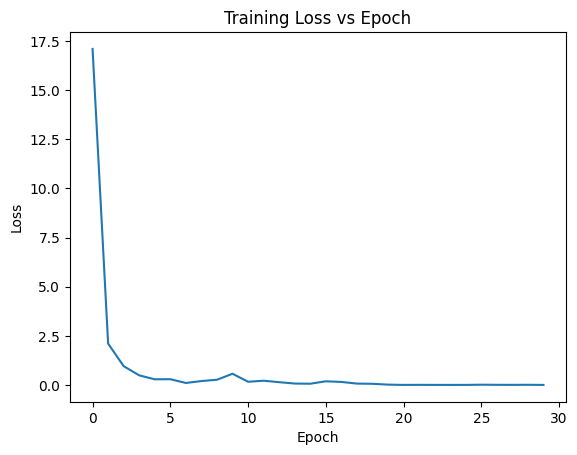

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('Training Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Evaluations

In [ ]:
scores = model_3.evaluate(image_test, label_test)
print(scores)

14/14 [==============================] - 8s 121ms/step - loss: 0.0153 - accuracy: 0.9977
[0.015258235856890678, 0.9977169036865234]


In [ ]:
y_pred = model_3.predict(image_test)

14/14 [==============================] - 2s 123ms/step


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

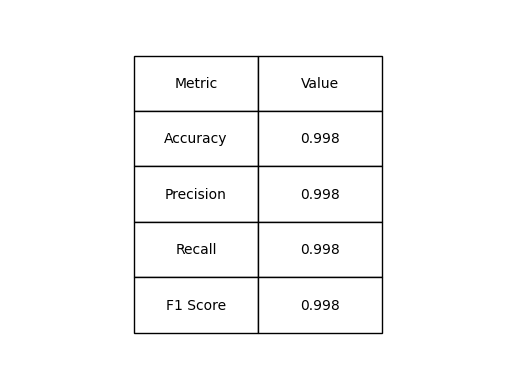

In [ ]:
y_pred_classes = np.argmax(y_pred, axis=1)
label_test_classes = np.argmax(label_test, axis=1)

accuracy = scores[1]
type(accuracy)

precision = precision_score(label_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(label_test_classes, y_pred_classes, average='weighted')
recall = recall_score(label_test_classes, y_pred_classes, average='weighted')

headers = ["Metric", "Value"]
data = [
    
    ["Accuracy", "%.3f" % accuracy],
    ["Precision", "%.3f" % precision],
    ["Recall", "%.3f" % recall],
    ["F1 Score", "%.3f" % f1],
]

fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=data, colLabels=headers, cellLoc='center', loc='center')

# Auto-size the columns
for key, cell in table.get_celld().items():
    cell.set_width(0.25)
    cell.set_height(0.15)

# Save the table as a PNG image
plt.savefig('metrics_table.png', bbox_inches='tight', dpi=300)

# Show the table in the notebook (optional)
plt.show()